In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
plt.rc('figure',figsize=(17,13))

[nltk_data] Downloading package vader_lexicon to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
f_data = pd.read_csv('F:\cbackup\Desktop\python\Tweets.csv', encoding='unicode_escape')
f_data.head(3)

Date          User  \
0  2022-06-29 21:23:33+00:00  JamesRosenTV   
1  2022-06-29 13:28:54+00:00   PeterSchiff   
2  2022-06-28 19:59:29+00:00   PeterSchiff   

                                               Tweet  
0  The chairman of the @federalreserve says "ther...  
1  The final read on Q1 GDP is now minus 1.6%. Si...  
2  Today's outside reversal day likely means the ...

In [8]:
#f_data.text =f_data.text.str.lower()

#Remove twitter handlers
f_data.Tweet = f_data.Tweet.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
f_data.Tweet = f_data.Tweet.apply(lambda x:re.sub(r'\B#\S+','',x))


# Remove URLS
f_data.Tweet = f_data.Tweet.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
f_data.Tweet = f_data.Tweet.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
f_data.Tweet = f_data.Tweet.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
f_data.Tweet = f_data.Tweet.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [9]:
sid = SIA()
f_data['sentiments']           = f_data['Tweet'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
f_data['Positive Sentiment']   = f_data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
f_data['Neutral Sentiment']    = f_data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
f_data['Negative Sentiment']   = f_data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

f_data.drop(columns=['sentiments'],inplace=True)

In [10]:
#Number of Words
f_data['Number_Of_Words'] = f_data.Tweet.apply(lambda x:len(x.split(' ')))
#Average Word Length
f_data['Mean_Word_Length'] = f_data.Tweet.apply(lambda x:np.round(np.mean([len(w) for w in x.split(' ')]),2) )


C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureW

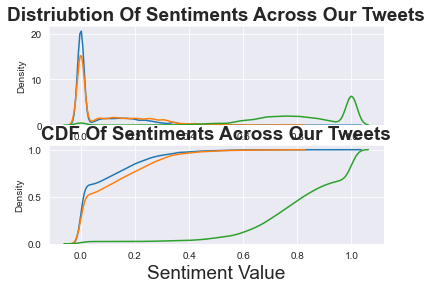

In [11]:
plt.subplot(2,1,1)
plt.title('Distriubtion Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1)
plt.subplot(2,1,2)
plt.title('CDF Of Sentiments Across Our Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(f_data['Negative Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,cumulative=True)
sns.kdeplot(f_data['Neutral Sentiment'],bw=0.1,cumulative=True)
plt.xlabel('Sentiment Value',fontsize=19)
plt.show()

In [20]:
#Sorting And Feature Engineering
f_data = f_data.sort_values(by='Date')
ft_data=f_data.copy()
ft_data['Date'] = pd.to_datetime(f_data['Date'],errors='coerce',format='%Y-%m-%d %H:%M:%S').dt.date

ft_data['year']         = pd.DatetimeIndex(ft_data['Date']).year
ft_data['month']        = pd.DatetimeIndex(ft_data['Date']).month
ft_data['day']          = pd.DatetimeIndex(ft_data['Date']).day
ft_data['day_of_year']  = pd.DatetimeIndex(ft_data['Date']).dayofyear
ft_data['quarter']      = pd.DatetimeIndex(ft_data['Date']).quarter
ft_data['season']       = ft_data.month%12 // 3 + 1

In [21]:
f_data=f_data.reset_index().drop(columns=['index'])
partitions = []
partitions.append(f_data.loc[44:np.round(len(f_data)/3,0)-1,:])
partitions.append(f_data.loc[np.round(len(f_data)/3,0):2*int(len(f_data)/3)-1,:])
partitions.append(f_data.loc[2*np.round(len(f_data)/3,0):3*int(len(f_data)/3)-1,:])



neg_part_means =[]
neg_part_std   =[]
pos_part_means =[]
pos_part_std   =[]
for part in partitions:
    neg_part_means.append(part['Negative Sentiment'].mean())
    neg_part_std.append(part['Negative Sentiment'].std())
    pos_part_means.append(part['Positive Sentiment'].mean())
    pos_part_std.append(part['Positive Sentiment'].std())
    
res_df = pd.DataFrame({'Positive Sentiment Mean':pos_part_means,'Negative Sentiment Mean':neg_part_means,'Positive Sentiment SD':pos_part_std,'Negative Sentiment SD':neg_part_std},
                     index = [f'Partition_{i}' for i in range(1,4)])


def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition_1_Mean'] == temp['Partition_2_Mean'])
    m2 = (temp['Partition_1_SD'] == temp['Partition_2_SD'])
    m3 = (temp['Partition_1_Mean'] < temp['Partition_2_Mean']+3) & (temp['Partition_1_Mean'] > temp['Partition_2_Mean']-3)
    m4 = (temp['Partition_1_SD'] < temp['Partition_2_SD']+3) & (temp['Partition_1_SD'] > temp['Partition_2_SD']-3)
    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition_1_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'),        df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m3, 'background-color: {}'.format('gold'),           df1['Partition_2_Mean'])
    df1['Partition_1_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_Mean'])
    df1['Partition_2_Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_Mean'])

    df1['Partition_1_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(~m2, 'background-color: {}'.format('salmon'),        df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m4, 'background-color: {}'.format('gold'),           df1['Partition_2_SD'])
    df1['Partition_1_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_1_SD'])
    df1['Partition_2_SD'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition_2_SD'])

    return df1



#res_df.style.apply(highlight_greater,axis=None)
res_df = res_df.T
res_df = pd.DataFrame(res_df.values,columns=res_df.columns,index=['Positive Sentiment','Negative Sentiment','Positive Sentiment','Negative Sentiment'])
res_df = pd.concat([res_df.iloc[:2,:],res_df.iloc[2:,:]],axis=1)
res_df.columns = ['Partition_1_Mean','Partition_2_Mean','Partition_3_Mean','Partition_1_SD','Partition_2_SD','Partition_3_SD']
res_df.style.apply(highlight_greater,axis=None)

In [22]:
fig = make_subplots(rows=3, cols=2)

for idx,prt in enumerate(partitions):
    fig.add_trace(
    go.Scatter(x=prt['Date'], y=prt['Positive Sentiment'],name=f'Positive Part {idx+1}'),
    row=idx+1, col=1)
    fig.add_trace(
    go.Scatter(x=prt['Date'], y=prt['Negative Sentiment'],name=f'Negative Part {idx+1}'),
    row=idx+1, col=2)

fig.update_layout(height=600, width=900, title_text="Distibution Of Daily Sentiments Over Our Time Line For Each Partition")
fig.show()

In [23]:
f_data.tail(3)

Date             User  \
1432  31-08-2016 22:19         MPBorman   
1433  31-08-2017 20:00    jamisonsocial   
1434  31-12-2017 17:15  news24tvchannel   

                                                  Tweet  Positive Sentiment  \
1432                         Examining the Impact of an            0.000001   
1433                          Next now expected in June            0.000001   
1434  Breaking New Year gift 1 25 more interest on y...            0.360001   

      Neutral Sentiment  Negative Sentiment  Number_Of_Words  Mean_Word_Length  
1432           1.000001            0.000001                5              4.40  
1433           1.000001            0.000001                5              4.20  
1434           0.640001            0.000001               14              4.14

In [25]:
fig = make_subplots(rows=4, cols=2, subplot_titles=('Observed Pos', 'Observed Neg', 'Trend Pos','Trend Neg','Seasonal Pos','Seasonal Neg','Residual Pos','Residual Neg'))
b_date_mean = ft_data.groupby(by='Date').mean().reset_index()

lbl = ['Positive','Negative']

for idx,column in enumerate(['Positive Sentiment','Negative Sentiment']):
    res = seasonal_decompose(b_date_mean[column], period=5, model='additive', extrapolate_trend='freq')
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.observed)), y=res.observed,name='{} Observed'.format(lbl[idx])),
    row=1, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.trend)), y=res.trend,name='{} Trend'.format(lbl[idx])),
    row=2, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.seasonal)), y=res.seasonal,name='{} Seasonal'.format(lbl[idx])),
    row=3, col=idx+1)
    
    fig.add_trace(
    go.Scatter(x=np.arange(0,len(res.resid)), y=res.resid,name='{} Residual'.format(lbl[idx])),
    row=4, col=idx+1)
            
fig.update_layout(height=600, width=900, title_text="Decomposition Of Our Sentiments into Trend,Level,Seasonality and Residuals")
fig.show()

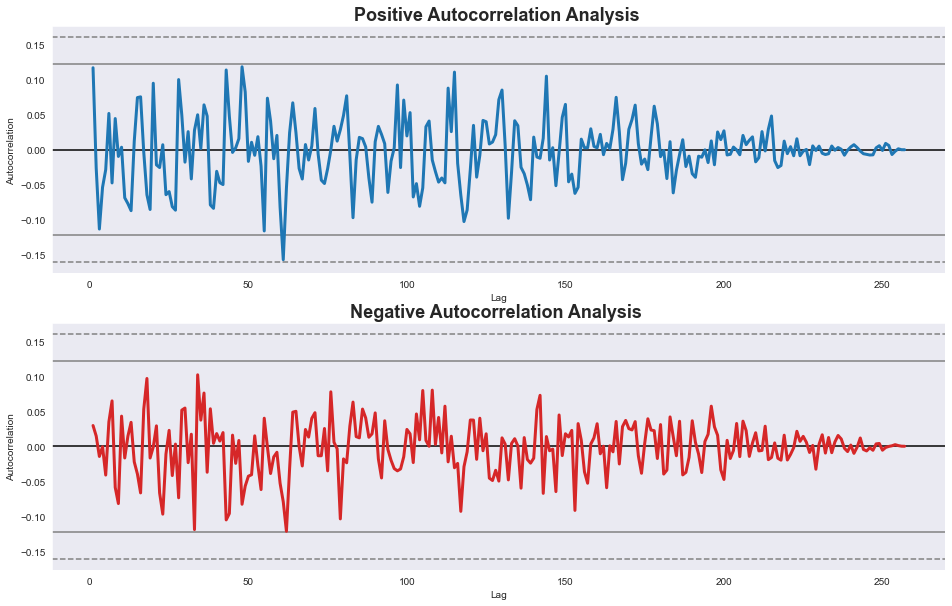

In [26]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 10))

ax[0].set_title('Positive Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Positive Sentiment'],ax=ax[0],lw=3)
ax[1].set_title('Negative Autocorrelation Analysis ',fontsize=18,fontweight='bold')
autocorrelation_plot(b_date_mean['Negative Sentiment'],ax=ax[1],color='tab:red',lw=3)
plt.show()

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



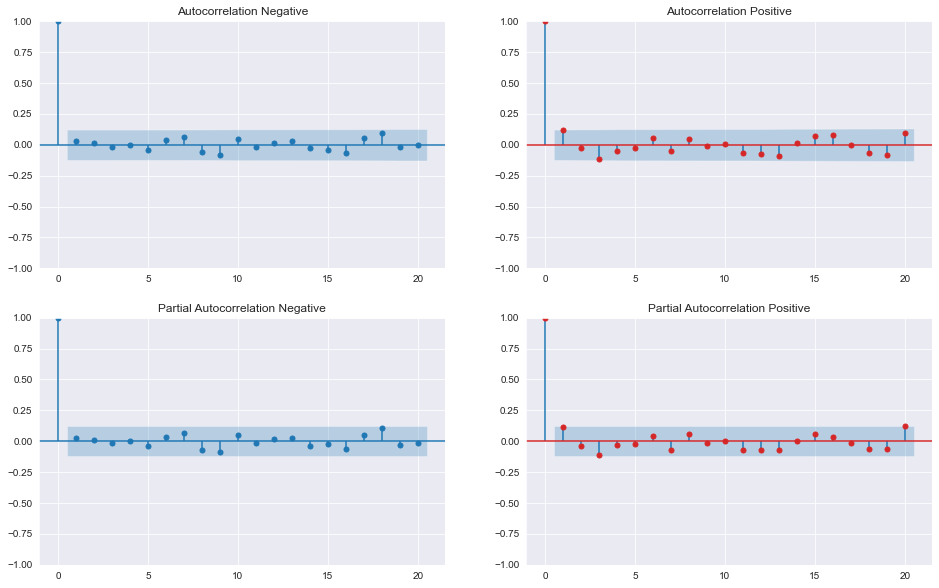

In [28]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax[0,0].set_ylim(-1.1,1.1)
ax[1,0].set_ylim(-1.1,1.1)
ax[0,1].set_ylim(-1.1,1.1)
ax[1,1].set_ylim(-1.1,1.1)

plot_acf(b_date_mean['Negative Sentiment'],lags=20, ax=ax[0,0],title='Autocorrelation Negative')
plot_pacf(b_date_mean['Negative Sentiment'],lags=20, ax=ax[1,0],title='Partial Autocorrelation Negative')
plot_acf(b_date_mean['Positive Sentiment'],lags=20, ax=ax[0,1],color='tab:red',title='Autocorrelation Positive')
plot_pacf(b_date_mean['Positive Sentiment'],lags=20, ax=ax[1,1],color='tab:red',title='Partial Autocorrelation Positive')
plt.show()

In [30]:
b_date_mean = ft_data.groupby(by='Date').mean().reset_index()
b_date_std = ft_data.groupby(by='Date').std().reset_index()


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Average Positive Sentiment',  'Daily Average Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_mean['Date'], y=b_date_mean['Positive Sentiment'],name='Positive Sentiment Mean'),
    row=1, col=1
)

    
#positive mean
fig.add_shape(type="line",
    x0=b_date_mean['Date'].values[0], y0=b_date_mean['Positive Sentiment'].mean(), x1=b_date_mean['Date'].values[-1], y1=b_date_mean['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean'
)

fig.add_annotation(x=b_date_mean['Date'].values[3], y=b_date_mean['Positive Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Positive Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10)



fig.add_trace(
    go.Scatter(x=b_date_mean['Date'], y=b_date_mean['Negative Sentiment'],name='Negative Sentiment Mean'),
    row=2, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_mean['Date'].values[0], y0=b_date_mean['Negative Sentiment'].mean(), x1=b_date_mean['Date'].values[-1], y1=b_date_mean['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

fig.add_annotation(x=b_date_mean['Date'].values[3], y=b_date_mean['Negative Sentiment'].mean(),
            text=r"$\mu : {:.2f}$".format(b_date_mean['Negative Sentiment'].mean()),
            showarrow=True,
            arrowhead=3,
            yshift=10,
            xref='x2', 
            yref='y2')



fig.add_annotation(x=b_date_mean['Date'].values[5], y=b_date_mean['Negative Sentiment'].mean()+0.01,
            text=r"Start Of Decline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')

fig.add_annotation(x=b_date_mean['Date'].values[15], y=.024,
            text=r"Start Of Incline",
            showarrow=True,
            arrowhead=6,
            yshift=10,
            xref='x2', 
            yref='y2')

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Average Change With Time")
fig.show()

In [32]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,subplot_titles=('Daily Deviation in Positive Sentiment',  'Daily Deviation in Negative Sentiment'))

fig.add_trace(
    go.Scatter(x=b_date_std['Date'], y=b_date_std['Positive Sentiment'],name='Positive Sentiment SD'),
    row=1, col=1
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['Date'].values[0], y0=b_date_std['Negative Sentiment'].mean(), x1=b_date_std['Date'].values[-1], y1=b_date_std['Negative Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x2', 
        yref='y2'
)

#negative mean
fig.add_shape(type="line",
    x0=b_date_std['Date'].values[0], y0=b_date_std['Positive Sentiment'].mean(), x1=b_date_std['Date'].values[-1], y1=b_date_std['Positive Sentiment'].mean(),
    line=dict(
        color="Red",
        width=2,
        dash="dashdot",
    ),
        name='Mean',
        xref='x1', 
        yref='y1'
)


fig.add_trace(
    go.Scatter(x=b_date_std['Date'], y=b_date_std['Negative Sentiment'],name='Negative Sentiment SD'),
    row=2, col=1
)

fig['layout']['xaxis2']['title'] = 'Date'
fig.update_layout(height=700, width=900, title_text="Sentiment Deviation Change With Time")
fig.show()

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.

C:\Users\Windows 10\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:1699: FutureWarning:

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.



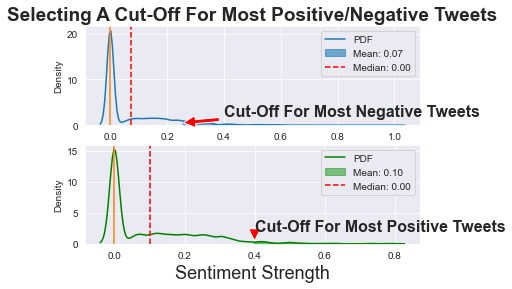

In [37]:
plt.subplot(2,1,1)
plt.title('Selecting A Cut-Off For Most Positive/Negative Tweets',fontsize=19,fontweight='bold')

ax0 = sns.kdeplot(f_data['Negative Sentiment'],bw=0.1)

kde_x, kde_y = ax0.lines[0].get_data()
ax0.fill_between(kde_x, kde_y, where=(kde_x>0.25) , 
                interpolate=True, color='tab:blue',alpha=0.6)

plt.annotate('Cut-Off For Most Negative Tweets', xy=(0.25, 0.5), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')

ax0.axvline(f_data['Negative Sentiment'].mean(), color='r', linestyle='--')
ax0.axvline(f_data['Negative Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Negative Sentiment'],r'Mean: {:.2f}'.format(f_data['Negative Sentiment'].mean()):f_data['Negative Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Negative Sentiment'].median()):f_data['Negative Sentiment'].median()})

plt.subplot(2,1,2)

ax1 = sns.kdeplot(f_data['Positive Sentiment'],bw=0.1,color='green')

plt.annotate('Cut-Off For Most Positive Tweets', xy=(0.4, 0.43), xytext=(0.4, 2),
            arrowprops=dict(facecolor='red', shrink=0.05),fontsize=16,fontweight='bold')
kde_x, kde_y = ax1.lines[0].get_data()
ax1.fill_between(kde_x, kde_y, where=(kde_x>0.4) , 
                interpolate=True, color='tab:green',alpha=0.6)
ax1.set_xlabel('Sentiment Strength',fontsize=18)


ax1.axvline(f_data['Positive Sentiment'].mean(), color='r', linestyle='--')
ax1.axvline(f_data['Positive Sentiment'].median(), color='tab:orange', linestyle='-')
plt.legend({'PDF':f_data['Positive Sentiment'],r'Mean: {:.2f}'.format(f_data['Positive Sentiment'].mean()):f_data['Positive Sentiment'].mean(),
            r'Median: {:.2f}'.format(f_data['Positive Sentiment'].median()):f_data['Positive Sentiment'].median()})

plt.show()


In [38]:
Most_Positive = f_data[f_data['Positive Sentiment'].between(0.4,1)]
Most_Negative = f_data[f_data['Negative Sentiment'].between(0.25,1)]

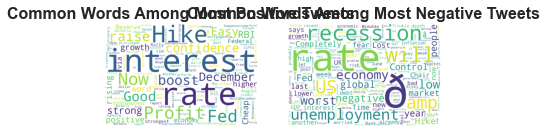

In [42]:
Most_Positive_Tweet = ' '.join(Most_Positive.Tweet)
Most_Negative_Tweet = ' '.join(Most_Negative.Tweet)


pwc = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(Most_Positive_Tweet)
nwc = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(Most_Negative_Tweet)

plt.subplot(1,2,1)
plt.title('Common Words Among Most Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Common Words Among Most Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

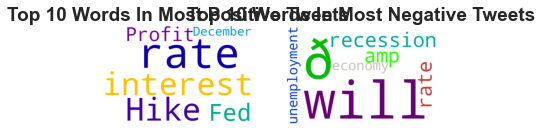

In [43]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:10]
top_10_neg = list(w2_dict.keys())[:10]

plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_pos))
plt.title('Top 10 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',background_color='white').generate(' '.join(top_10_neg))
plt.title('Top 10 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c)
plt.axis('off')
plt.show()